<a href="https://colab.research.google.com/github/educarrascov/educarrascov/blob/main/Algoritmo_gen%C3%A9tico_completo_TSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
Genetic algorithms work by iterating over generations of populations and evaluation how well these populations solve a problem. At the end of a generation, the best individuals are selected to produce the next generation. 

The code presented in this blog has been adapted from:


**Zaccone G. (2019). Natural Computing with Python: Learn to implement genetic and evolutionary algorithms for problem solving in a pythonic way. BPB Publications.**



# Imports
First we import all necessary modules.

In [ ]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt

# Data Representation
Because we are going to work with the simplest form of the TSP, we need a way to represent the data:

In [ ]:
#Create class to handle "cities"

class City:
    def __init__(self,name, x, y):
        self.name = name
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.name)+ ")"


# How the algorithm works?

## The concept of individual
An individual can be seen as a single instance of the problem, for this case it's easy to see that the individual is the sequence of "cities" and the order that they are visited.

## Fitness
Genetic algorithms mimic natural structures using the idea of "Survival of the fittest", so it's important to define a common fitness function for all individuals. For this case, the fitness of an individual is the sum of the distance for each pair of consecutive cities, including the sum of the last city in the sequence and the first (because TSP forms a loop).
>$Fitness=[\sum_{i=1}^{N-1} Distance(City_{i},City_{i+1})]+Distance(City_{N},City_{1})$

This "Distance" function is just the euclidian distance between each city.

In [ ]:
#Create a fitness function

class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

## Mutation and Breeding
The algorithm creates the next generations using two methods, either mutating single individuals based on a probability, or "mating" two individual to create a new one. Here we define all necesarry functions to perform the algorithm.

In [ ]:
#Create our initial population
#Route generator
#This method randomizes the order of the cities, this mean that this method creates a random individual.
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route


#Create first "population" (list of routes)
#This method created a random population of the specified size.

def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population


#Create the genetic algorithm
#Rank individuals
#This function takes a population and orders it in descending order using the fitness of each individual
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    sorted_results=sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)
    return sorted_results



#Create a selection function that will be used to make the list of parent routes

def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults



#Create mating pool

def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool




#Create a crossover function for two parents to create one child
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        

    childP2 = [item for item in parent2 if item not in childP1]
    print(startGene, endGene)

    print(parent1)
    print(parent2)

    print(childP1)
    print(childP2)
    child = childP1 + childP2

    print(child)
    return child

#Create function to run crossover over full mating pool

def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children




#Create function to mutate a single route
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual



#Create function to run mutation over entire population

def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop



#Put all steps together to create the next generation

def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

## The genetic algorithm
With all these function defined, all that is left is to write the definition of the genetic algorithm.

In [ ]:
#Final step: create the genetic algorithm

def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = [1 / rankRoutes(pop)[0][1]]
    print("Initial distance: " + str(progress[0]))
    
    for i in range(1, generations+1):
        
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
        if i%50==0:
          print('Generation '+str(i),"Distance: ",progress[i])
        
        
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.title('Best Fitness vs Generation')
    plt.tight_layout()
    plt.show()

    
    
    return bestRoute

## Testing
Know we create a list of cities and run the algorithm, this should return the best route found in the last generation.

Initial distance: 360.619360301362
4 4
[(2), (1), (4), (3), (0)]
[(1), (0), (4), (3), (2)]
[]
[(1), (0), (4), (3), (2)]
[(1), (0), (4), (3), (2)]
0 1
[(3), (0), (2), (1), (4)]
[(4), (0), (2), (1), (3)]
[(3)]
[(4), (0), (2), (1)]
[(3), (4), (0), (2), (1)]
0 0
[(0), (2), (1), (4), (3)]
[(4), (2), (0), (3), (1)]
[]
[(4), (2), (0), (3), (1)]
[(4), (2), (0), (3), (1)]
4 4
[(4), (2), (0), (3), (1)]
[(1), (0), (3), (2), (4)]
[]
[(1), (0), (3), (2), (4)]
[(1), (0), (3), (2), (4)]
0 4
[(1), (4), (3), (0), (2)]
[(2), (1), (4), (0), (3)]
[(1), (4), (3), (0)]
[(2)]
[(1), (4), (3), (0), (2)]
0 2
[(0), (4), (3), (2), (1)]
[(3), (2), (4), (1), (0)]
[(0), (4)]
[(3), (2), (1)]
[(0), (4), (3), (2), (1)]
3 4
[(4), (2), (0), (3), (1)]
[(1), (0), (4), (3), (2)]
[(3)]
[(1), (0), (4), (2)]
[(3), (1), (0), (4), (2)]
2 2
[(1), (0), (4), (3), (2)]
[(0), (2), (1), (4), (3)]
[]
[(0), (2), (1), (4), (3)]
[(0), (2), (1), (4), (3)]
0 2
[(1), (2), (0), (3), (4)]
[(2), (4), (1), (3), (0)]
[(1), (2)]
[(4), (3), (0)]
[(

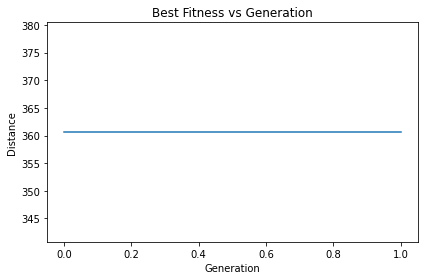

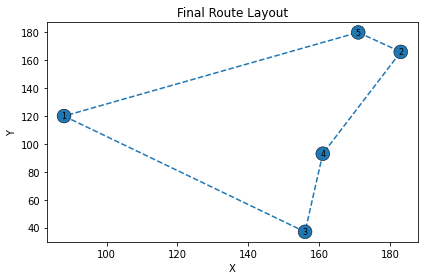

In [ ]:
#Running the genetic algorithm
#Create list of cities

cityList = []

for i in range(0,5):
    cityList.append(City(name = i, x=int(random.random() * 200), y=int(random.random() * 200)))


best_route=geneticAlgorithm(population=cityList, popSize=30, eliteSize=20, mutationRate=0.01, generations=1)
x=[]
y=[]
for i in best_route:
  x.append(i.x)
  y.append(i.y)
x.append(best_route[0].x)
y.append(best_route[0].y)
plt.plot(x, y, '--o')
plt.xlabel('X')
plt.ylabel('Y')
ax=plt.gca()
plt.title('Final Route Layout')
bbox_props = dict(boxstyle="circle,pad=0.3", fc='C0', ec="black", lw=0.5)
for i in range(1,len(cityList)+1):
  ax.text(cityList[i-1].x, cityList[i-1].y, str(i), ha="center", va="center",
            size=8,
            bbox=bbox_props)
plt.tight_layout()
plt.show()